# Single Peak Simulations

In this set of simulations, we will test power spectrum parameterization performance on power spectra simulated with a single peak.

This simulation test checks the use case of identifying and quantifying the dominant peak in a power spectrum.

To do so, we will simulate power spectra with a single peak with an aperiodic component in 'fixed' mode, all with varying parameters.

Performance will be evaluated by examining how well the algorithm can reconstruct periodic and aperiodic parameters for the simulated power spectra.

In [1]:
%matplotlib inline

In [2]:
from os.path import join as pjoin

import numpy as np
from scipy.stats import spearmanr

from fooof import FOOOFGroup, fit_fooof_3d
from fooof.sim import gen_group_power_spectra
from fooof.sim.utils import set_random_seed

In [3]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from plts import *
from sims import *
from utils import *
from analysis import *
from settings import *

## Settings

In [4]:
# Set random seed
set_random_seed(303)

In [5]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [6]:
# Set a folder name (for saving data & figures)
FOLDER = '01_one-peak/'

In [7]:
# Data & Model Setting
GEN_SIMS = False
SAVE_SIMS = False
FIT_MODELS = False
SAVE_MODELS = False
SAVE_GTH = False

In [8]:
# Run Settings
SAVE_FIG = True
PLT_LOG = True

# If not plotting in log, turn off log-defined plot limits
if not PLT_LOG:
    YLIMS_AP = YLIMS_KN = YLIMS_CF = YLIMS_PW = YLIMS_BW = None
    YTICKS_CF = YTICKS_PW = YTICKS_BW = None

In [9]:
# Check the conditions to simulate across: noise level
print('NLVS: ', NLVS)

NLVS:  [0.0, 0.025, 0.05, 0.1, 0.15]


In [10]:
# Set the number of power spectra (per condition)
n_psds = N_PSDS

## Simulation Tests: One Peak Across Noise Levels

First, simulate power spectra with one peak, and measure how well we can reconstruct each variable.

### Simulate Power Spectra

In [11]:
# Use generators to sample peak & aperiodic parameters
peaks = gen_peak_def(1)
aps = gen_ap_def()

In [12]:
# Get data sizes
n_conds = len(NLVS)
n_freqs = int((F_RANGE[1] - F_RANGE[0]) / F_RES + 1)

In [13]:
# Generate or load power spectra
data_name = 'single_peak_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_conds, n_psds, n_freqs])
    sim_params = [None] * n_conds

    # Generate simulated power spectra
    for n_ind, nlv in enumerate(NLVS):
        freqs, psds[n_ind, :, :], sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE, aps, peaks, nlv,
                                    F_RES, return_params=True)
    
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(data_name, FOLDER, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name, FOLDER)
    
# Check shape
print('n_conds, n_spectra, n_freqs : ', psds.shape)

n_conds, n_spectra, n_freqs :  (5, 1000, 153)


In [14]:
# Extract ground truth values
peak_truths, ap_truths = get_ground_truth(sim_params)

# Save out ground truth values - added by AT
if SAVE_GTH:
    save_ground_truth(data_name, FOLDER, peak_truths, ap_truths)

print('Peak Truths: \n', peak_truths.shape)
print('AP Truths: \n', ap_truths.shape)

Peak Truths: 
 (5, 1000, 3)
AP Truths: 
 (5, 1000, 2)


##### Check the empirical levels of noise expected  (empirical noise floor)

The empirical noise levels should be the same as the noise scaling factor set in the simulations.

This is just a check, to estimate the actual error off the simulations. 

Note that the noise values also determine the amount of variance that can be expected to be captured by fitting.

If parameterization captures more variance than expected given the amount of simulated noise, this suggests the algorithm is overfitting. 

In [15]:
emp_nlv = []
for nlv in NLVS:
    temp = []

    # Within each noise level, get the average squared 'error'
    for it in range(n_psds):
        temp.append(np.mean(np.random.normal(0, nlv, len(freqs))**2))
    
    # Get the average 'error' per noise level
    emp_nlv.append(np.mean(temp))

In [16]:
# Compare simulated values to empirical values
print('Simulated NLV Values:')
print_list(NLVS)
print('Empirical NLV Values:')
print_list(np.sqrt(emp_nlv))

Simulated NLV Values:
['0.0000', '0.0250', '0.0500', '0.1000', '0.1500']
Empirical NLV Values:
['0.0000', '0.0250', '0.0500', '0.0999', '0.1501']


### Check Average Errors & Stats

AT has added these parts for testing our method on the signle peak sim data.

In [17]:
# load the output parameters
aperiodic_params_all = np.load('../data/01_one-peak/aperiodic_params_all_log_npeak1_AT.npy')
peak_params_all = np.load('../data/01_one-peak/peak_params_all_log_npeak1_AT.npy')
r_squared_all = np.load('../data/01_one-peak/r_squared_all_log_npeak1_AT.npy')
error_all = np.load('../data/01_one-peak/error_all_log_npeak1_AT.npy')

print(aperiodic_params_all.shape)
# throw away the column 1 of aperiodic_params_all
aperiodic_params_all = np.delete(aperiodic_params_all, 1, axis=2)
print(aperiodic_params_all.shape)
peak_fits = peak_params_all
ap_fits = aperiodic_params_all
r2_fits = r_squared_all
err_fits = error_all


print('Peak Fit Results:')
print(peak_fits.shape)
print(ap_fits.shape)
print(err_fits.shape)
print(r2_fits.shape)

# load the ground truths
# peak_truths = np.load('single_peak_sims_peak_truths.npy')
# ap_truths = np.load('single_peak_sims_ap_truths.npy')

(5, 1000, 3)
(5, 1000, 2)
Peak Fit Results:
(5, 1000, 3)
(5, 1000, 2)
(5, 1000)
(5, 1000)


In [18]:
# Calculate errors
peak_errors = calc_errors(peak_truths, peak_fits)
ap_errors = calc_errors(ap_truths, ap_fits)

In [19]:
# Pull out error per peak parameter
cf_errors = peak_errors[:, :, 0]
pw_errors = peak_errors[:, :, 1]
bw_errors = peak_errors[:, :, 2]

# Pull out error per aperiodic parameter
off_errors = ap_errors[:, :, 0]
exp_errors = ap_errors[:, :, 1]

In [20]:
# Check overall fit quality
temp = r2_fits.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.nanmin(temp), np.nanmax(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.nanmedian(temp)))

Min/Max R^2: 	0.1813 	1.0000
Median  R^2: 	0.9771


In [21]:
# Collect data together
datas = {
    'CF' : cf_errors,
    'PW' : pw_errors,
    'BW' : bw_errors,
    'OFF' : off_errors,
    'EXP' : exp_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [22]:
# Print out the average error for each parameter
#   Also prints out the average model error and R^2 per noise level
with np.printoptions(precision=4, suppress=True):
    for label, data in datas.items():
        print(label, '\n\t', np.nanmedian(data, 1))

CF 
	 [0.1302 0.1381 0.2853 1.3272 3.0531]
PW 
	 [0.0061 0.0138 0.0414 0.0873 0.0642]
BW 
	 [ 0.665   0.771   1.5811  9.7348 10.7348]
OFF 
	 [0.0154 0.0288 0.0445 0.0744 0.0993]
EXP 
	 [0.0096 0.0191 0.0346 0.0684 0.0834]
ERR 
	 [0.0029 0.0174 0.0337 0.0676 0.0985]
R^2 
	 [0.9998 0.9949 0.9824 0.9375 0.8792]


In [23]:
# Check if the amount of error correlates with the noise level
print('Correlations of median error with noise level:')
print('\n\t\t  r-val\t\tp-val')
print('\tCF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(cf_errors, axis=1))))
print('\tPW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(pw_errors, axis=1))))
print('\tBW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(bw_errors, axis=1))))
print('\tOFF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(off_errors, axis=1))))
print('\tEXP\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(exp_errors, axis=1))))

Correlations of median error with noise level:

		  r-val		p-val
	CF	: 1.000 	0.00
	PW	: 0.900 	0.04
	BW	: 1.000 	0.00
	OFF	: 1.000 	0.00
	EXP	: 1.000 	0.00


/home/at87/Desktop/CanonParams_Asilomar/Asilomar/Code/plts.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  ax = sns.violinplot(data=data.T, cut=0, scale='area', linewidth=2.5,


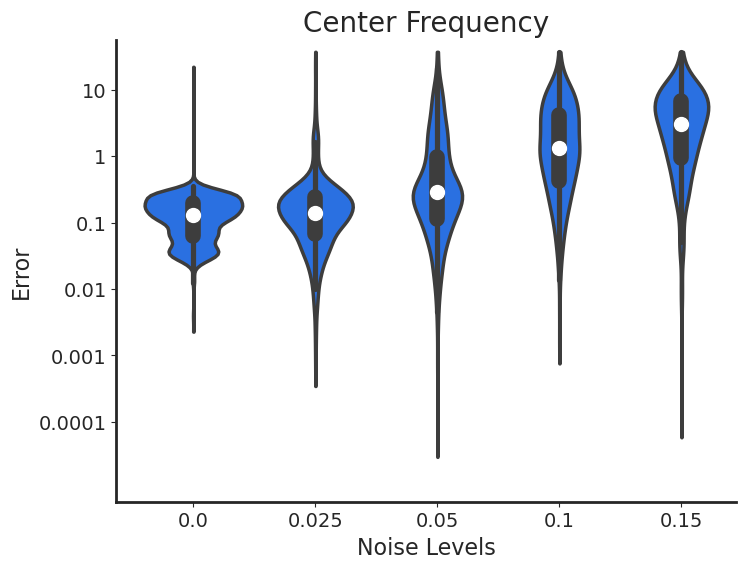

In [24]:
# Plot the error of peak center frequency reconstruction
plot_errors_violin(cf_errors, 'Center Frequency', plt_log=PLT_LOG, 
                   ylim=YLIMS_CF, yticks=YTICKS_CF,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'cf_error'))

/home/at87/Desktop/CanonParams_Asilomar/Asilomar/Code/plts.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  ax = sns.violinplot(data=data.T, cut=0, scale='area', linewidth=2.5,


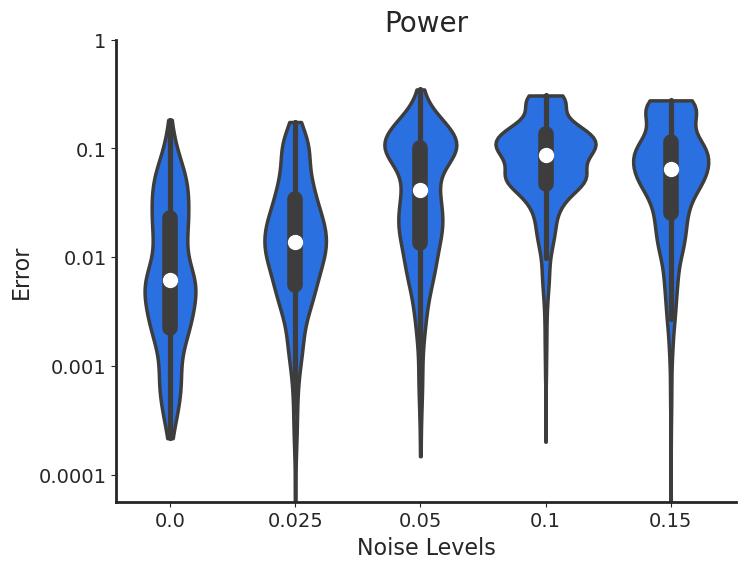

In [25]:
# Plot the error of peak power reconstruction
plot_errors_violin(pw_errors, 'Power', plt_log=PLT_LOG, 
                   ylim=YLIMS_PW, yticks=YTICKS_PW,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'pw_error'))

/home/at87/Desktop/CanonParams_Asilomar/Asilomar/Code/plts.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  ax = sns.violinplot(data=data.T, cut=0, scale='area', linewidth=2.5,


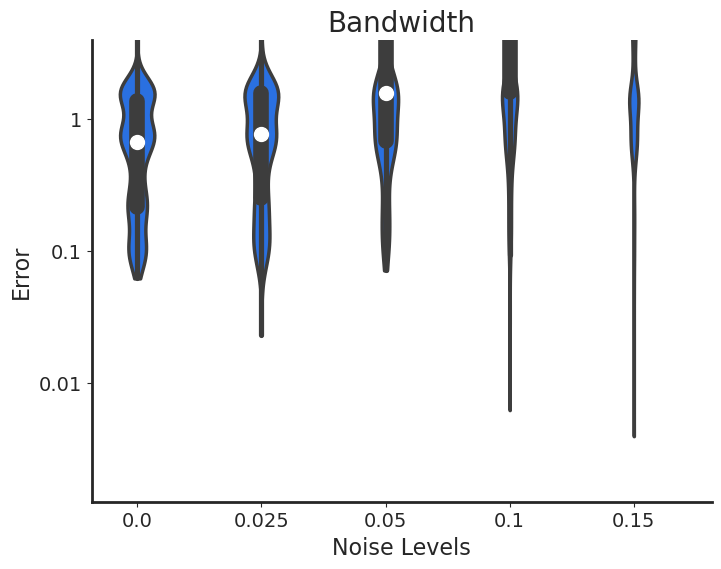

In [26]:
# Plot the error of peak bandwidth reconstruction
plot_errors_violin(bw_errors, 'Bandwidth', plt_log=PLT_LOG,
                   ylim=YLIMS_BW, yticks=YTICKS_BW,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'bw_error'))

/home/at87/Desktop/CanonParams_Asilomar/Asilomar/Code/plts.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  ax = sns.violinplot(data=data.T, cut=0, scale='area', linewidth=2.5,


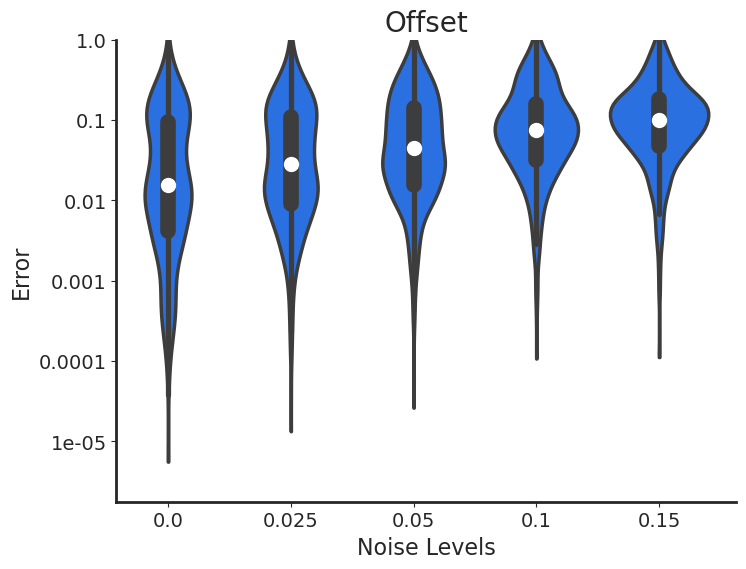

In [27]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(off_errors, 'Offset', plt_log=PLT_LOG, ylim=YLIMS_AP,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'off_error'))

/home/at87/Desktop/CanonParams_Asilomar/Asilomar/Code/plts.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  ax = sns.violinplot(data=data.T, cut=0, scale='area', linewidth=2.5,


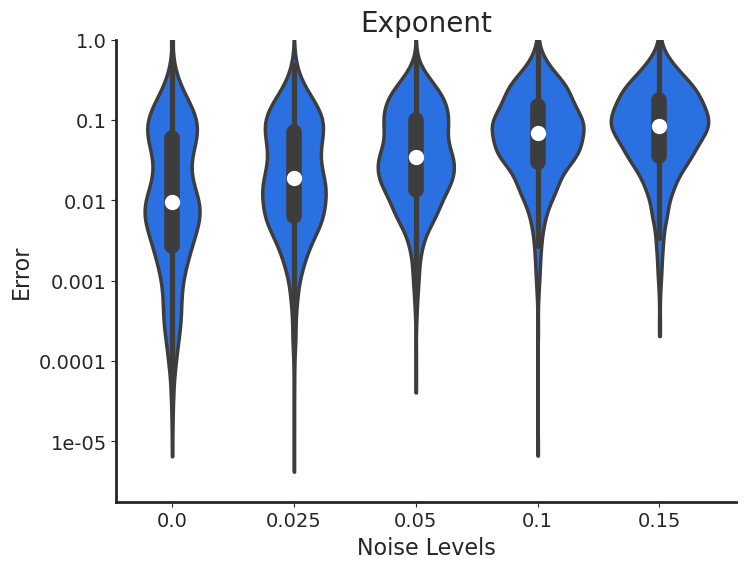

In [28]:
# Plot the error of aperiodic exponent reconstruction
plot_errors_violin(exp_errors, 'Exponent', plt_log=PLT_LOG, ylim=YLIMS_AP,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'exp_error'))

/home/at87/Desktop/CanonParams_Asilomar/Asilomar/Code/plts.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  ax = sns.violinplot(data=data.T, cut=0, scale='area', linewidth=2.5,


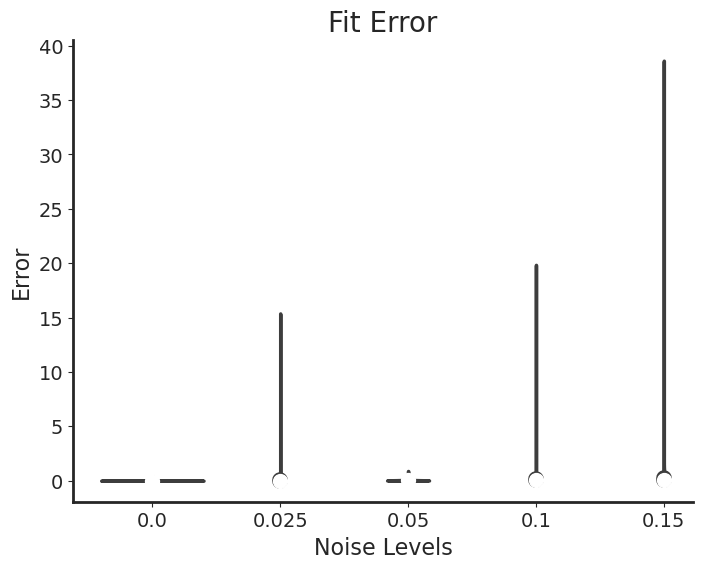

In [29]:
# Plot the amount of error across noise levels
plot_errors_violin(err_fits, 'Fit Error', y_label='Error', plt_log=False,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_error'))

/home/at87/Desktop/CanonParams_Asilomar/Asilomar/Code/plts.py:97: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  ax = sns.violinplot(data=data.T, cut=0, scale='area', linewidth=2.5,


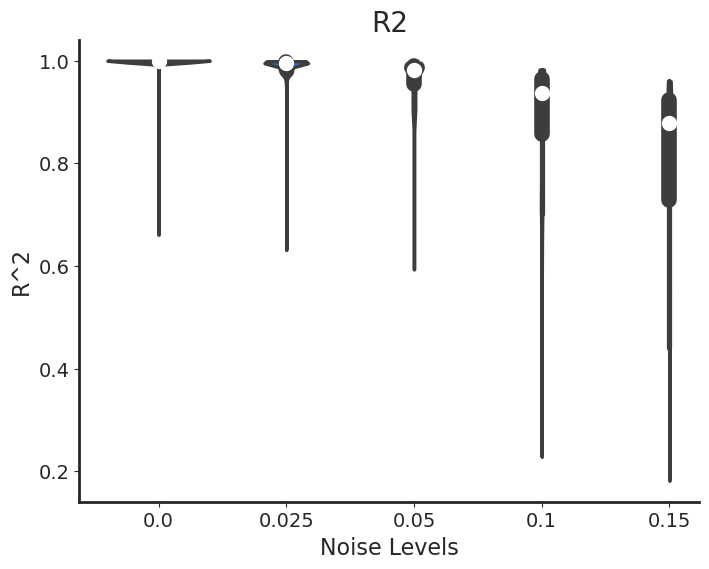

In [30]:
# Plot the goodness-of-fit (R^2) across noise levels
plot_errors_violin(r2_fits, 'R2', y_label='R^2', plt_log=False,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_r_squared'))